In [1]:
%pip install ../ # Use local jaxDSP package rather than published one.

import jax.numpy as jnp
import numpy as np
import time

from IPython.display import Audio
from scipy.io.wavfile import read as readwav

from jaxdsp import training, processor_graph
from jaxdsp.processors import freeverb, processors_to_graph_config, processor_names_from_graph_config
from jaxdsp.plotting import plot_train, plot_optimization
from jaxdsp.loss import LossOptions
from jaxdsp.processors.constants import DEFAULT_SAMPLE_RATE

Processing /Users/khiner/Development/jaxdsp
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for jaxdsp: filename=jaxdsp-0.3.1-py3-none-any.whl size=22243 sha256=6bddb35a2c124a71232548660e5cdd595a5c853fa85727e9c962968ce4fb197d
  Stored in directory: /private/var/folders/ml/r9zrbg2s0hq7cyxx40fw_k800000gn/T/pip-ephem-wheel-cache-i0wvdrl6/wheels/f1/a5/b7/313c75bc0afa33627e970f8339fd2e2d68a1dc70b987148cef
Successfully built jaxdsp
  Attempting uninstall: jaxdsp
    Found existing installation: jaxdsp 0.3.1
    Uninstalling jaxdsp-0.3.1:
      Successfully uninstalled jaxdsp-0.3.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
sample_rate, X = readwav('./audio/speech-male.wav')
frame_size = 2048
tail_length = 5 * sample_rate
# X = np.concatenate([X, np.zeros(tail_length)]) # let it ring out
X = np.concatenate([X, np.zeros(frame_size - len(X) % frame_size)]) # make it a multiple of `frame_size`
Xs = np.array(np.split(X, len(X) // frame_size)) # split into frames

default_loss_opts = LossOptions(
    weights={"sample": 1.0},
    distance_types={"sample": "L2"},
)
spectral_loss_opts = LossOptions(
    weights={"cumsum_freq": 1.0},
    distance_types={"frequency": "L1"},
#    stft_window="hamming",
)
optimizer_opts = {"name": "Adam",'params': {'step_size': 0.02}}
print('Num frames: {}'.format(len(Xs)))

Num frames: 122


In [3]:
from jaxdsp.params import params_to_float

def evaluate_processors(processors, params_target, Xs, loss_opts=default_loss_opts, optimization_opts=optimizer_opts, num_batches=100, reference_fn=None, plot_loss_history=True, plot_params_history=True, title=None):
    graph_config = processors_to_graph_config(processors)
    processor_names = processor_names_from_graph_config(graph_config)
    trainer = training.IterativeTrainer(graph_config, loss_opts, optimization_opts, track_history=True)
    carry_target = (params_target, trainer.state)
    start = time.time()
    for i in range(num_batches):
        X = Xs[i % len(Xs)]
        carry_target, Y_target = processor_graph.tick_buffer(carry_target, X, processor_names)
        trainer.step(X, Y_target)

    params_estimated = params_to_float(trainer.params)
    print('Train time: {:.3E} s'.format(time.time() - start))
    print('Loss: {:.3E}'.format(trainer.loss))
    print('Estimated params: ', params_estimated)

    X_eval = Xs[0]
    _, Y_estimated = processor_graph.tick_buffer((params_estimated, trainer.state), X_eval, processor_names)
    _, Y_target = processor_graph.tick_buffer(carry_target, X_eval, processor_names)
    Y_reference = reference_fn(X_eval, carry_target[0]) if reference_fn is not None else None

    plot_train(trainer, params_target, X_eval, Y_target, Y_estimated, Y_reference, title=title, plot_loss_history=plot_loss_history, plot_params_history=plot_params_history)
    
    return X_eval, Y_target, Y_estimated

Train time: 2.031E+01 s
Loss: 3.138E+01
Estimated params:  [[{'damp': 1.0, 'dry': 0.0, 'room_size': 0.16707786917686462, 'wet': 0.41287070512771606, 'width': 1.0}]]


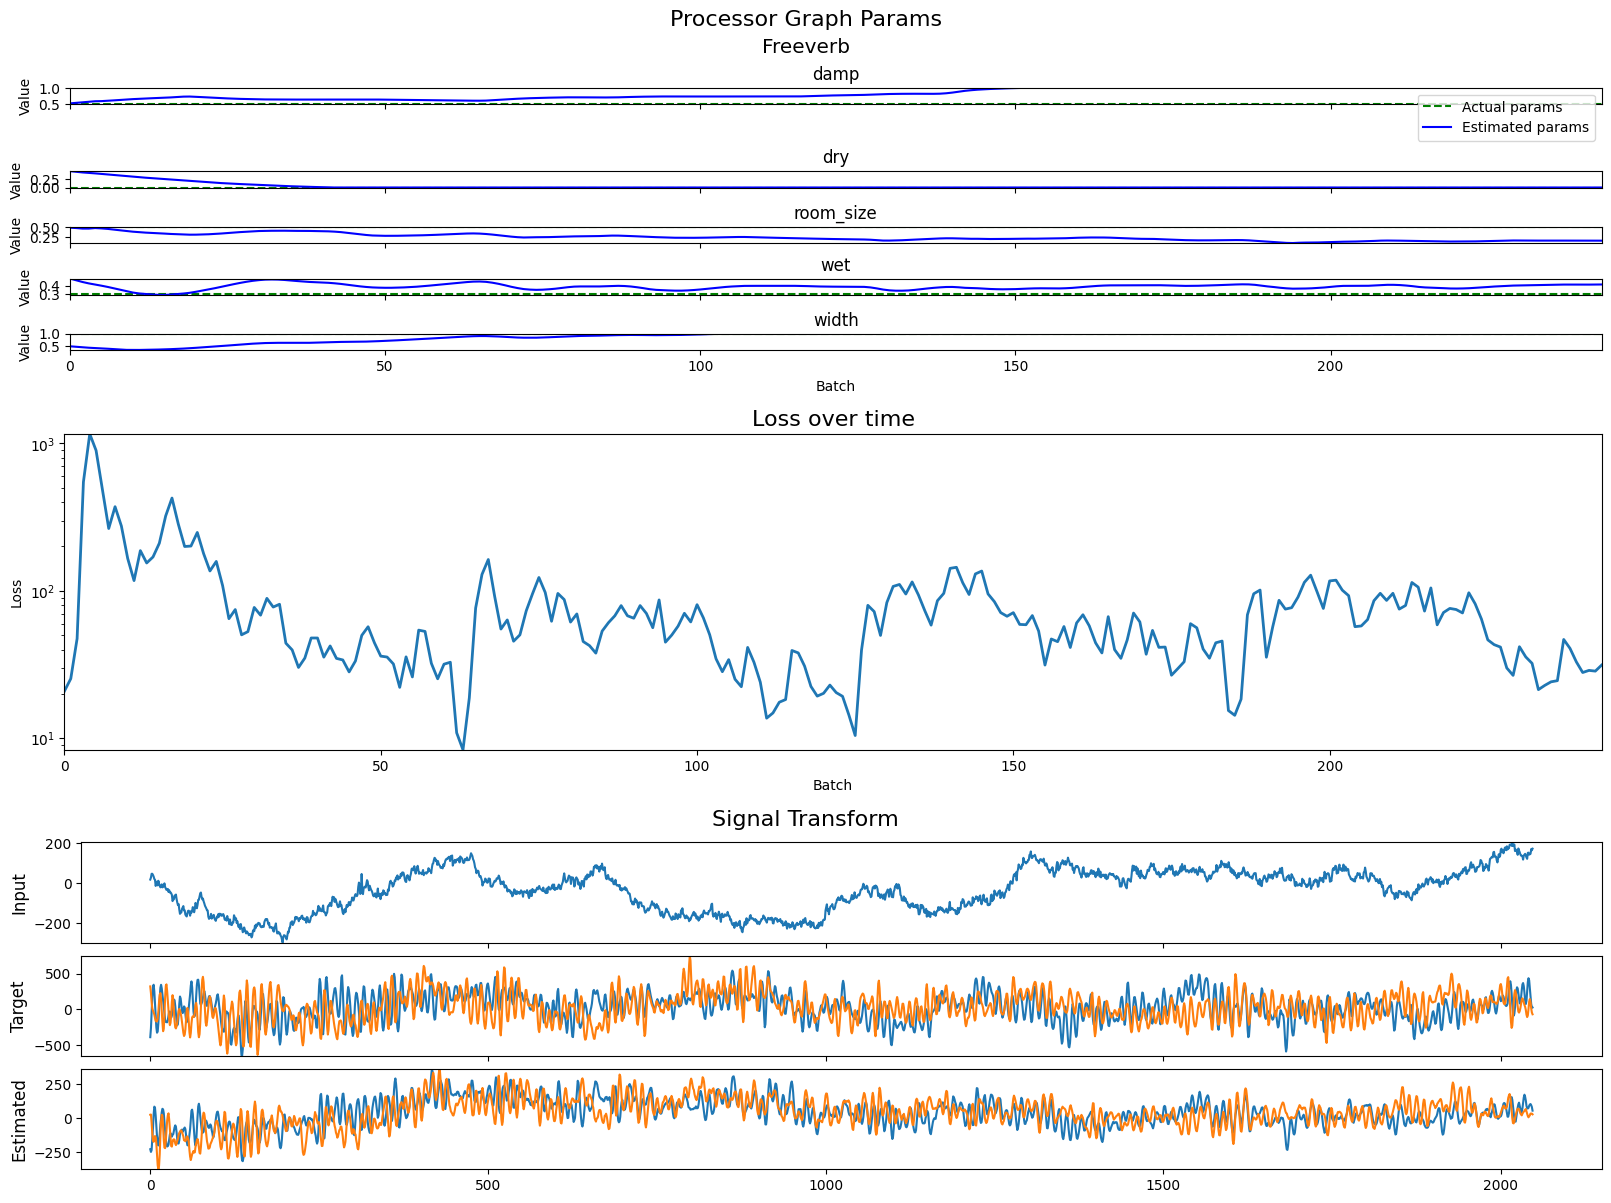

In [4]:
X_eval, Y_target, Y_estimated = evaluate_processors([[freeverb]], [[{
    'wet': 0.3,
    'dry': 0.0,
    'width': 1.0,
    'damp': 0.5,
    'room_size': 0.5,
}]], Xs, num_batches=len(Xs) * 2, loss_opts=spectral_loss_opts)

In [5]:
from IPython.display import Audio

Audio(X_eval, rate=DEFAULT_SAMPLE_RATE)